# Convolutional Neural Network - Emotion Dataset

## Enabling and testing the GPU

First, you'll need to enable GPUs for the notebook:

- Navigate to Edit→Notebook Settings
- select GPU from the Hardware Accelerator drop-down

Next, we'll confirm that we can connect to the GPU with tensorflow:

In [1]:
# import tensorflow as tf
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))

## Enabling and testing the TPU

First, you'll need to enable TPUs for the notebook:

- Navigate to Edit→Notebook Settings
- select TPU from the Hardware Accelerator drop-down

Next, we'll check that we can connect to the TPU:

In [2]:
# %tensorflow_version 2.x
# import tensorflow as tf
# print("Tensorflow version " + tf.__version__)

# try:
#   tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
#   print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
# except ValueError:
#   raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)
# tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

### Importing the libraries

In [66]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,LearningRateScheduler

In [67]:
tf.__version__

'2.3.1'

## Part 1 - Data Preprocessing

In [68]:
# from google.colab import drive
# drive.mount('/content/drive')

In [69]:
# IMAGE_PATH = 'drive/My Drive/facial_expressions/images'
# CSV_PATH = 'drive/My Drive/facial_expressions/data/legend.csv'

In [70]:
IMAGE_PATH = './Documents/ML/facial_expressions/images'
CSV_PATH = './Documents/ML/facial_expressions/data/legend.csv'
MODEL_CHECKPOINT = './Documents/ML/facial_expressions/checkpoint/model_checkpoint'
HAARCASCADE = './Documents/ML/facial_expressions/haarcascade_frontalface_default.xml'
TARGET_SIZE = (64, 64)

In [71]:
dataset = pd.read_csv(CSV_PATH, dtype=str)
dataset['emotion'] = dataset['emotion'].str.lower()

X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

In [72]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13690 entries, 0 to 13689
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   image    13690 non-null  object
 1   emotion  13690 non-null  object
dtypes: object(2)
memory usage: 214.0+ KB


In [73]:
dataset.head()

,image,emotion
0,facial-expressions_2868588k.jpg,anger
1,facial-expressions_2868585k.jpg,surprise
2,facial-expressions_2868584k.jpg,disgust
3,facial-expressions_2868582k.jpg,fear
4,Aaron_Eckhart_0001.jpg,neutral


In [74]:
dataset.isnull().sum()

image      0
emotion    0
dtype: int64

### Splitting the dataframe into the Training set and Test set

In [75]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(dataset, test_size = 0.2, random_state = 0)

### Preprocessing the Training set

In [76]:
# Applying geometrical transformations to all the images to to avoid "overfitting"

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)                          

training_set = train_datagen.flow_from_dataframe(
                                                 directory=IMAGE_PATH,
                                                 dataframe=train_df,
                                                 x_col="image",
                                                 y_col="emotion",
                                                 subset="training",
                                                 color_mode="grayscale",
                                                 seed=42,
                                                 target_size = TARGET_SIZE,
                                                 shuffle=True,
                                                 batch_size = 32,
                                                 class_mode="categorical")

Found 10952 validated image filenames belonging to 8 classes.


### Preprocessing the Test set

In [77]:
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_dataframe(
                                            directory=IMAGE_PATH,
                                            dataframe=test_df,
                                            x_col="image",
                                            y_col="emotion",
                                            subset="training",
                                            color_mode="grayscale",
                                            seed=42,
                                            target_size = TARGET_SIZE,
                                            shuffle=True,
                                            batch_size = 32,
                                            class_mode="categorical")

Found 2738 validated image filenames belonging to 8 classes.


### Visualizing Training Dataset

#### Analyzing categorical training dataset (atleast 500 images required for each category for better predictions)

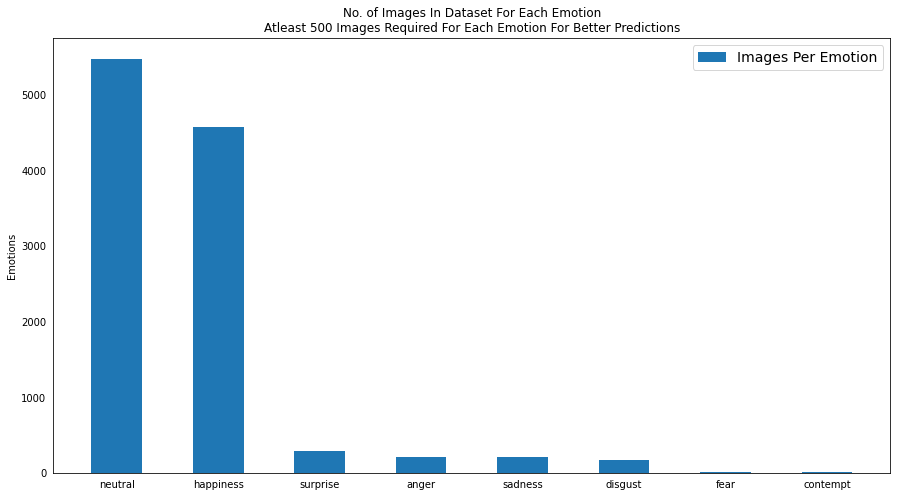

In [78]:
num_classes = len(training_set.class_indices)
labels = to_categorical(np.unique(training_set.classes), num_classes=num_classes)
xvals = []
height = train_df['emotion'].value_counts()

for i in range(0, len(labels)):
  max_index = np.argmax(labels[i])
  emotion_detection = ('neutral', 'happiness', 'surprise', 'anger', 'sadness', 'disgust', 'fear', 'contempt')
  emotion_prediction = emotion_detection[max_index]
  xvals.append(emotion_prediction)

f, ax = plt.subplots(figsize=(15,8)) # figsize = (width, height)
plt.bar(xvals, height, align='center', width = 0.5, label='Images Per Emotion')
plt.ylabel('No. of Images')
plt.ylabel('Emotions')
plt.title('No. of Images In Dataset For Each Emotion\nAtleast 500 Images Required For Each Emotion For Better Predictions')
plt.tick_params(width=0)
ax.legend(fontsize = 14)

## Part 2 - Building the CNN

### Initialising the CNN

In [16]:
cnn = tf.keras.models.Sequential()

### Step 1 - Convolution

In [17]:
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[64, 64, 1]))

### Step 2 - Pooling

In [18]:
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

### Adding a second convolutional layer

In [19]:
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

### Step 3 - Flattening

In [20]:
cnn.add(tf.keras.layers.Flatten())

### Step 4 - Full Connection (Fully Connected ANN)

In [21]:
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))

### Step 5 - Output Layer

##### For binary classification (dog or cat), flow_from_directory='binary' and "sigmoid" function could be used and loss='binary_crossentropy'.

##### For multi class classification, flow_from_directory='categorical' and "soft max" function could be used and loss='categorical_crossentropy'.

In [22]:
cnn.add(tf.keras.layers.Dense(units=8, activation='softmax'))

## Part 3 - Training the CNN

### Compiling the CNN

In [23]:
cnn.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [24]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               802944    
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 1

### Training the CNN on the Training set and evaluating it on the Test set

In [25]:
#setting a few callbacks
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5, mode = 'auto')
checkpoint = ModelCheckpoint(filepath=MODEL_CHECKPOINT,save_best_only=True,monitor='val_loss',save_weights_only=False)

#what is the accuracy now
print("PreTraining Evaluation: ")
(eval_loss, eval_accuracy) = cnn.evaluate(test_set, batch_size=32)
print(f'[INFO] accuracy: {eval_accuracy * 100}%') 
print(f'[INFO] Loss: {eval_loss}')
print()
print("Training Model: ")
history = cnn.fit(x = training_set, validation_data = test_set, epochs = 100, callbacks = [early_stopping, checkpoint])

PreTraining Evaluation: 
86/86 [==============================] - 7s 83ms/step - loss: 2.0861 - accuracy: 0.0278
[INFO] accuracy: 2.775748632848263%
[INFO] Loss: 2.0860793590545654

Training Model: 
Epoch 1/100
343/343 [==============================] - ETA: 0s - loss: 0.9040 - accuracy: 0.6353WARNING:tensorflow:From c:\users\acer\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\training\tracking\tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./Documents/ML/facial_expressions/checkpoint\model_checkpoint\assets
343/343 [==============================] - 91s 264ms/step - loss: 0.9040 - accuracy: 0.6353 - val

In [26]:
print(history.history)

{'loss': [0.9039934277534485, 0.6904528737068176, 0.6380431652069092, 0.6059911251068115, 0.5740904211997986, 0.5603725910186768, 0.5382421612739563, 0.5140824913978577, 0.5020188093185425, 0.4808173179626465, 0.4795377552509308, 0.45472797751426697, 0.4495736360549927, 0.43097123503685, 0.4229046702384949, 0.4131046235561371, 0.4049766957759857, 0.3909205496311188, 0.38207879662513733, 0.37373366951942444, 0.365263968706131, 0.3581783175468445], 'accuracy': [0.6353177428245544, 0.7563915252685547, 0.7773009538650513, 0.7852447032928467, 0.7941928505897522, 0.8030496835708618, 0.811358630657196, 0.8165631890296936, 0.8214024901390076, 0.8308071494102478, 0.8320854902267456, 0.8375639319419861, 0.8385682702064514, 0.8440467715263367, 0.848520815372467, 0.8490686416625977, 0.8548210263252258, 0.8610299229621887, 0.8634952306747437, 0.8649562001228333, 0.8669649362564087, 0.8694302439689636], 'val_loss': [0.6835831999778748, 0.6042442321777344, 0.5483251214027405, 0.544981837272644, 0.540

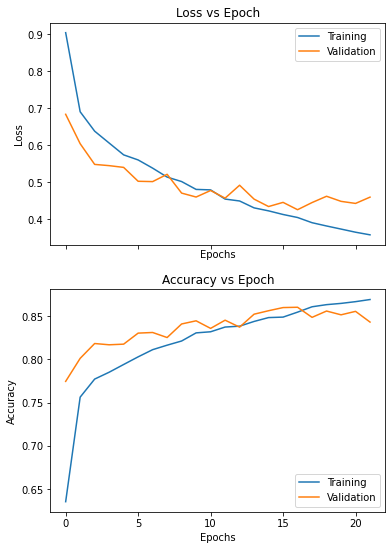

In [27]:
def plotLearningCurve(df):
  #input pandas dataframe containg training history
  #output learning curves 
  fig, axes = plt.subplots(2,1,figsize=(6,9),sharex=True)

  axes[0].plot(df["loss"])  #training loss
  axes[0].plot(df["val_loss"])  #validation loss
  axes[0].set_title("Loss vs Epoch")
  axes[0].set_ylabel("Loss")
  axes[0].set_xlabel("Epochs")
  axes[0].legend(["Training","Validation"],loc="upper right")

  axes[1].plot(df["accuracy"])  #training loss
  axes[1].plot(df["val_accuracy"])  #validation loss
  axes[1].set_title("Accuracy vs Epoch")
  axes[1].set_ylabel("Accuracy")
  axes[1].set_xlabel("Epochs")
  axes[1].legend(["Training","Validation"],loc="lower right")
  
plotLearningCurve(history.history)

In [28]:
print("PostTraining Evalutaion:")

(eval_loss, eval_accuracy) = cnn.evaluate(test_set, batch_size=32)
print(f'[INFO] accuracy: {eval_accuracy * 100}%') 
print(f'[INFO] Loss: {eval_loss}')

PostTraining Evalutaion:
86/86 [==============================] - 18s 204ms/step - loss: 0.4599 - accuracy: 0.8433
[INFO] accuracy: 84.33163166046143%
[INFO] Loss: 0.4599463939666748


We now serialize the model to JSON and save the model weights in an hd5 file so that we can make use of this file to make predictions rather than training the network again. You can do this task by using the below code.

In [79]:
from tensorflow.keras.models import load_model
model = load_model(MODEL_CHECKPOINT)
model.summary()

model_json = model.to_json()
with open("./Documents/ML/facial_expressions/checkpoint/model_checkpointOpenCv", "w") as json_file:
  json_file.write(model_json)
model.save_weights("model.h5")
print("Saved model to disk")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               802944    
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 1

## Part 4 - Making a prediction over test images

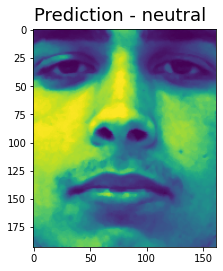

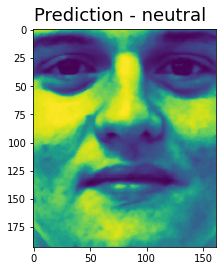

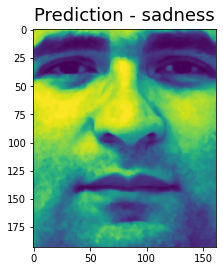

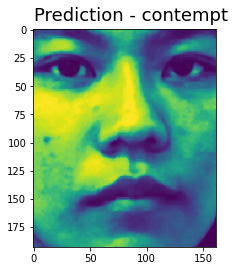

In [107]:
import numpy as np
from keras.preprocessing import image
import matplotlib.image as mpimg

for i in range (0, 4):
  test_image = image.load_img(f'./Documents/ML/facial_expressions/test/test{i+1} .jpg', target_size = (64, 64), color_mode="grayscale")
  test_image = image.img_to_array(test_image) # Converting test image to array
  test_image = np.expand_dims(test_image, axis = 0) # expand dimension of a single image to the batch_size i.e, [] -> [[]]
  predictions = model.predict(test_image)

  max_index = np.argmax(predictions[0])
  emotion_detection = ('anger', 'surprise', 'disgust', 'fear', 'neutral', 'happiness', 'sadness', 'contempt')
  emotion_prediction = emotion_detection[max_index]

  plt.imshow(mpimg.imread(f'./Documents/ML/facial_expressions/test/test{i+1} .jpg'))
  plt.text(x = 0.5, y = -8, s = f'Prediction - {emotion_prediction}', fontsize=18)
  plt.show()

### Testing the model in Real-time using OpenCV and WebCam

In [31]:
!pip install opencv-python

In [13]:
import os
import cv2
import numpy as np
from keras.models import model_from_json
from keras.preprocessing import image

After importing the model weights we have imported a haar cascade file that is designed by open cv to detect the frontal face.

In [14]:
model = model_from_json(open("./Documents/ML/facial_expressions/checkpoint/model_checkpointOpenCv", "r").read())
model.load_weights('model.h5')

# Load some pre-trained data on face frontals from opencv (haar cascade algorithm)
face_haar_cascade = cv2.CascadeClassifier(HAARCASCADE)

In [15]:
frameWidth = 480
frameHeight = 640
cap = cv2.VideoCapture(0)
cap.set(3, frameWidth)  # For frame width the id is 3
cap.set(4, frameHeight)  # For frame height the id is 4
cap.set(10, 150)  # For brightness the id is 10

while True:
    success, frame = cap.read()

    converted_image = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    faces_detected = face_haar_cascade.detectMultiScale(converted_image)

    for (x,y,w,h) in faces_detected:
      cv2.rectangle(frame, (x, y), (x+w, y+h), (255,0,0))

      roi_gray = converted_image[y:y+w, x:x+h]
      roi_gray=cv2.resize(roi_gray,(64, 64))
    
      image_pixels = image.img_to_array(roi_gray)
      image_pixels = np.expand_dims(image_pixels, axis = 0)
      image_pixels /= 255

      predictions = model.predict(image_pixels)
      max_index = np.argmax(predictions[0])
      emotion_detection = ('anger', 'surprise', 'disgust', 'fear', 'neutral', 'happiness', 'sadness', 'contempt')
      emotion_prediction = emotion_detection[max_index]

      cv2.putText(frame, emotion_prediction, (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 3)

    resize_image = cv2.resize(frame, (350, 350))
    cv2.imshow('Emotion',resize_image)

    # This key is automatically pressed after a delay of 1sec for the video frame to change
    key = cv2.waitKey(1)

    # Stop if Q key is pressed
    if key == 81 or key == 113:
        break

cap.release()
cv2.destroyAllWindows

<function destroyAllWindows>